Pietra Gullo Salgado Chaves - 14603822

Classificação de redes, objetivo de verficar se a hipótese "redes do mesmo tipo (biológica, social e tecnológica) seguem o mesmo modelo" é válida.

Redes escolhidas para análise:

Redes Sociais

- Haggle Human Proximity network (2006) - https://networks.skewed.de/net/contact
- Philippines Ambassador Bombing (2001) - https://networks.skewed.de/net/ambassador
- CEO Club Memberships - https://networks.skewed.de/net/ceo_club

Redes Biológicas:
- Little Rock Lake food web (1991) - https://networks.skewed.de/net/foodweb_little_rock
-  E. coli transcription network (2002)  - https://networks.skewed.de/net/ecoli_transcription
- Yeast transcription network (2002) - https://networks.skewed.de/net/yeast_transcription

Redes tecnológicas:

- Route Views AS graphs (1997-1998) - 19971108: https://networks.skewed.de/net/route_views#19971108_draw

- Internet Top Pop Bellcanada: https://networks.skewed.de/net/internet_top_pop

- Software Dependencies Junit_draw: https://networks.skewed.de/net/software_dependencies#junit_draw


Usando os modelos: Watts-Strogatz, Erdós-Rényi, Barabási e Waxman

In [1]:
from numpy  import *
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import pandas as pd
import networkx as nx
from scipy import stats
from sklearn.decomposition import PCA
import math

##Funções inicias para utilização posterior
Nessa parte iremos ler as redes, fazer o tratamento incial e declarar algumas funções que serão usadas posteriormente, afim de manter uma boa modularização.

In [12]:
#lendo os arquivos e criando as redes
#redes sociais
df = pd.read_csv('/content/edges_haggle.csv', usecols=[0, 1], header=None)
human_prox = nx.from_pandas_edgelist(df, source=0, target=1)

df = pd.read_csv('/content/edges_ambassador.csv', usecols=[0, 1], header=None)
ambass = nx.from_pandas_edgelist(df, source=0, target=1)

df = pd.read_csv('/content/edges_ceo.csv', usecols=[0, 1], header=None)
ceo = nx.from_pandas_edgelist(df, source=0, target=1)

#redes tecnológicas
df = pd.read_csv('/content/edges_bellcanada.csv', usecols=[0, 1], header=None)
bell = nx.from_pandas_edgelist(df, source=0, target=1)

df = pd.read_csv('/content/edges_junit.csv', usecols=[0, 1], header=None)
junit = nx.from_pandas_edgelist(df, source=0, target=1)

df = pd.read_csv('/content/edges_route.csv', usecols=[0, 1], header=None)
edges = nx.from_pandas_edgelist(df, source=0, target=1)


df = pd.read_csv('/content/little_rock.csv', usecols=[0, 1], header=None)
rock = nx.from_pandas_edgelist(df, source=0, target=1)


df = pd.read_csv('/content/ecoli.csv', usecols=[0, 1], header=None)
ecoli = nx.from_pandas_edgelist(df, source=0, target=1)

df = pd.read_csv('/content/yeast.csv', usecols=[0, 1], header=None)
yeast = nx.from_pandas_edgelist(df, source=0, target=1)

In [3]:
#quero visualizar caracteristicas da rede como numero de arestas, vértices e grau médio
#além de manter uma variavel guardando cada valor para construir os grafos modelos para comparar depois
def info(G):
  n = G.number_of_nodes()
  m = G.number_of_edges()
  print(f"N:{n}")
  print(f"M:{m}")
  vk = sum(d for _, d in G.degree()) / n
  print(f"Grau médio: {vk:.2f}")
  return n, vk


In [4]:
def padronizar_rede(g):
   g.remove_edges_from(nx.selfloop_edges(g))
   g = g.to_undirected()
   Gcc = sorted(nx.connected_components(g), key=len, reverse=True)
   G = g.subgraph(Gcc[0])
   G = nx.convert_node_labels_to_integers(G, first_label=0)
   return G

Nessa parte definimos funções que dado o número de vértice e grau geram uma rede seguindo cada um dos modelos, a rede retornada já é considerando apenas a maior componente e de forma que o label comece em 0

---



In [5]:
#construir as redes modelos
def erdos(n, g):
  p = g/(n-1)
  GER = nx.gnp_random_graph(n, p, seed=None, directed=False)
  GER = padronizar_rede(GER)
  return GER

def watts(n, g):
  k = int(g/2)
  p = 0.1
  GWS = nx.watts_strogatz_graph(n, k, p, seed=None)
  GWS = padronizar_rede(GWS)
  return GWS

def barabasi(n, g):
  m = int(g/2)
  GBA = nx.barabasi_albert_graph(n, m)
  GBA = padronizar_rede(GBA)
  return GBA

def waxxman(n, g):
  alpha = 0.4
  beta = 0.1
  GWA = nx.waxman_graph(n, alpha=alpha, beta=beta, domain=(0, 0, 1, 1))
  GWA = padronizar_rede(GWA)
  return GWA

In [6]:
#iremos usar coeficiente de clustering, caminho medio, assortatividade do grau
#1o momento (grau medio) e variância da distribuição de grau
def momment_of_degree_distribution(G,m):
    M = 0
    N = len(G)
    for i in G.nodes:
        M = M + G.degree(i)**m
    M = M/N
    return M

def calcular_medidas(g):
  g = padronizar_rede(g)
  clustering = nx.average_clustering(g)
  path_length = nx.average_shortest_path_length(g)
  assortativity = nx.degree_assortativity_coefficient(g)
  degree_mean = momment_of_degree_distribution(g,1)
  var = momment_of_degree_distribution(g,2)-(momment_of_degree_distribution(g,1)**2)
  return clustering, path_length, assortativity, degree_mean, var


##Utilizando os modelos já citados para gerar novas redes
Nessa parte iremos gerar várias redes seguindo cada um dos modelos para cada uma das redes (biológicas, sociais e tecnológicas) que temos. Iremos manter apenas os valores das medidas que nos interessam para cada uma das redes.

In [7]:
#Agora precisamos pra cada rede gerar vários grafos pelos modelos que usamos
#e aplicarmos o cálculo das medidas em cima do gerado, para salvar
#tanto dos modelos quanto da rede original
#passada uma rede pra gerar toda a analise
modelos = [
    ("GER", erdos),
    ("GWS", watts),
    ("GBA", barabasi),
    ("GWA", waxxman)
]

def computar_medidas(g, nome):
  cl, pat, ass, dg, var = calcular_medidas(g)
  return{
      "clustering": cl,
      "avg_path_length": pat,
      "assortatividade": ass,
      "dg_medio": dg,
      "var": var,
      "modelo": nome
  }

#essa função irá retornar um catalogo das redes geradas(medidas aplicadas nessas redes)
#junto as medidas da propria rede
def gerar_analise(g):

  g = padronizar_rede(g)
  redes_geradas = []
  n, vk = info(g)

  for model, func in modelos:
    n_iter = 50 #numero de iterações
    while(n_iter>0):
      G_model = func(n, vk)
      A = computar_medidas(G_model, model)
      n_iter -= 1
      redes_geradas.append(A)

  atual = computar_medidas(g, "original")
  return redes_geradas, atual

##Classificação: Regressão logística

Aqui iremos calcular qual a probabilidade de classificação da rede "g" para cada uma das classes (modelos geradores)

In [8]:
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

def classificador(g):

  redes_geradas, atual = gerar_analise(g)
  df_sint = pd.DataFrame(redes_geradas).dropna()
  print(df_sint)
  df_orig = pd.DataFrame([atual])

  x_treino = df_sint[["clustering","avg_path_length","assortatividade","dg_medio","var"]]
  y_treino = df_sint["modelo"]
  x_orig = df_orig[["clustering","avg_path_length","assortatividade","dg_medio","var"]]

  pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("LR",  LogisticRegression())
  ])

  pipeline.fit(x_treino, y_treino)

  pred = pipeline.predict(x_orig)
  probs = pipeline.predict_proba(x_orig)

  #PCA
  target_marker = "x"
  target_color = "orange"
  markers = ['o', 'h', '^', 'v', 'p']
  colors = ['blue', 'red', 'green', 'purple']

  pca_pipeline = Pipeline([
      ("scaler", StandardScaler()),
      ("pca", PCA(n_components=2))
  ])

  pca_pipeline.fit(x_treino)
  X_transformed = pca_pipeline.transform(x_treino)
  target_transformed = pca_pipeline.transform(x_orig)


  fig = plt.figure(figsize=(12, 8))
  plt.scatter(target_transformed[:, 0], target_transformed[:, 1], marker=target_marker, c=target_color, label="Network")
  for idx, model in enumerate(np.unique(y_treino)):

      class_X = X_transformed[y_treino == model]

      plt.scatter(class_X[:, 0], class_X[:, 1], marker=markers[idx], c=colors[idx], label=model)

  plt.title("PCA das redes")
  plt.xlabel("Componente principal 1")
  plt.ylabel("Componente principal 2")
  plt.legend()
  plt.grid(True)
  plt.show()

  return pred, probs, pipeline.classes_


##Aplicando classificação pras redes e utilizando PCA pra visualizar

N:274
M:2124
Grau médio: 15.50


<ipython-input-3-147f9f899d1c>:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  vk = sum(d for _, d in G.degree()) / n


     clustering  avg_path_length  assortatividade   dg_medio        var modelo
0      0.058089         2.323922        -0.008746  15.722628  14.404816    GER
1      0.058992         2.348868        -0.037755  15.248175  13.529650    GER
2      0.052896         2.308147        -0.006421  16.029197  15.254622    GER
3      0.059264         2.318628        -0.008366  15.810219  14.978582    GER
4      0.054840         2.330820        -0.008563  15.554745  14.633864    GER
..          ...              ...              ...        ...        ...    ...
195    0.051517         2.578728         0.003185  11.394161  13.275294    GWA
196    0.045824         2.584717        -0.048335  11.189781  13.343545    GWA
197    0.042159         2.561616         0.014536  11.532847  12.438702    GWA
198    0.039358         2.564824         0.013594  11.481752  13.694922    GWA
199    0.046467         2.636347        -0.003626  10.613139  12.514572    GWA

[200 rows x 6 columns]


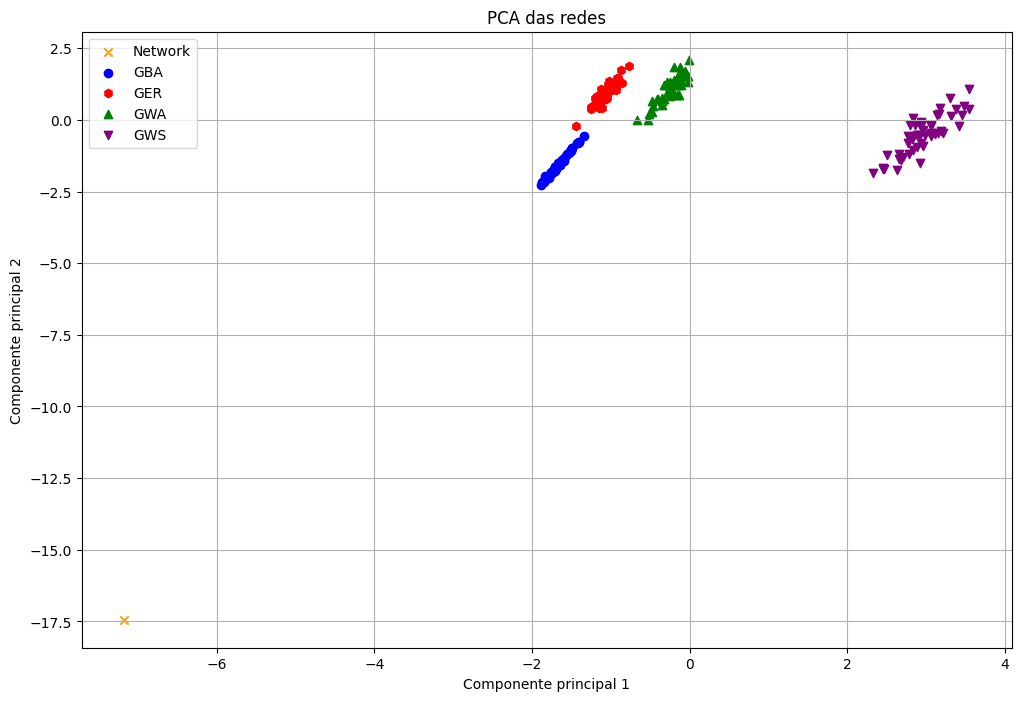

N:16
M:69
Grau médio: 8.62


<ipython-input-3-147f9f899d1c>:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  vk = sum(d for _, d in G.degree()) / n
/usr/local/lib/python3.11/dist-packages/networkx/algorithms/assortativity/correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return float((xy * (M - ab)).sum() / np.sqrt(vara * varb))


     clustering  avg_path_length  assortatividade  dg_medio       var modelo
0      0.555538         1.425000        -0.083423  8.625000  1.734375    GER
1      0.583251         1.433333        -0.215796  8.500000  3.750000    GER
2      0.434375         1.500000        -0.187097  7.500000  1.875000    GER
3      0.575735         1.433333        -0.120036  8.500000  3.000000    GER
4      0.558460         1.458333        -0.111172  8.250000  4.937500    GER
..          ...              ...              ...       ...       ...    ...
194    0.000000         1.666667        -0.500000  1.500000  0.250000    GWA
196    0.000000         1.333333        -1.000000  1.333333  0.222222    GWA
197    0.000000         2.821429        -0.666667  1.750000  0.437500    GWA
198    0.000000         1.666667        -0.500000  1.500000  0.250000    GWA
199    0.000000         1.333333        -1.000000  1.333333  0.222222    GWA

[184 rows x 6 columns]


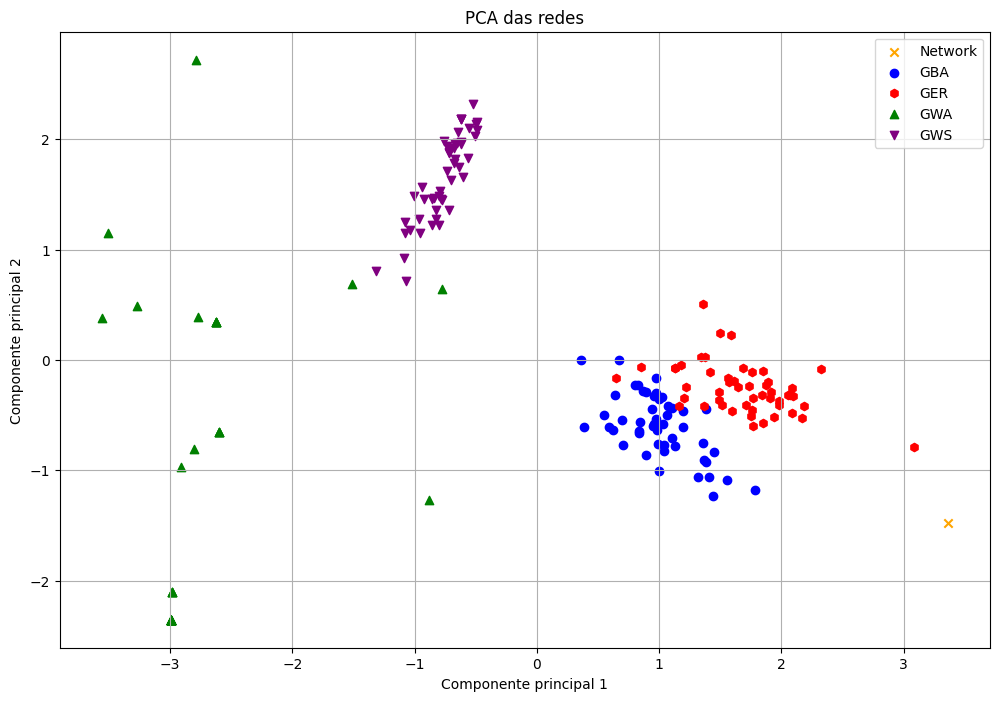

N:40
M:95
Grau médio: 4.75


<ipython-input-3-147f9f899d1c>:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  vk = sum(d for _, d in G.degree()) / n
/usr/local/lib/python3.11/dist-packages/networkx/algorithms/assortativity/correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return float((xy * (M - ab)).sum() / np.sqrt(vara * varb))


     clustering  avg_path_length  assortatividade  dg_medio       var modelo
0      0.094270         2.583215        -0.062851  4.263158  2.983380    GER
1      0.062393         3.318489        -0.262925  2.923077  1.917160    GER
2      0.155873         2.334615         0.007577  5.200000  4.860000    GER
3      0.167024         2.421795         0.028627  5.050000  3.447500    GER
4      0.142449         2.403846        -0.152278  5.000000  4.800000    GER
..          ...              ...              ...       ...       ...    ...
195    0.000000         4.438095        -0.489362  1.866667  0.515556    GWA
196    0.000000         4.608696        -0.427230  2.086957  1.122873    GWA
197    0.000000         3.771429        -0.342466  2.000000  1.714286    GWA
198    0.033333         4.556150        -0.180556  2.294118  1.619377    GWA
199    0.000000         4.867424        -0.069728  2.242424  1.274564    GWA

[199 rows x 6 columns]


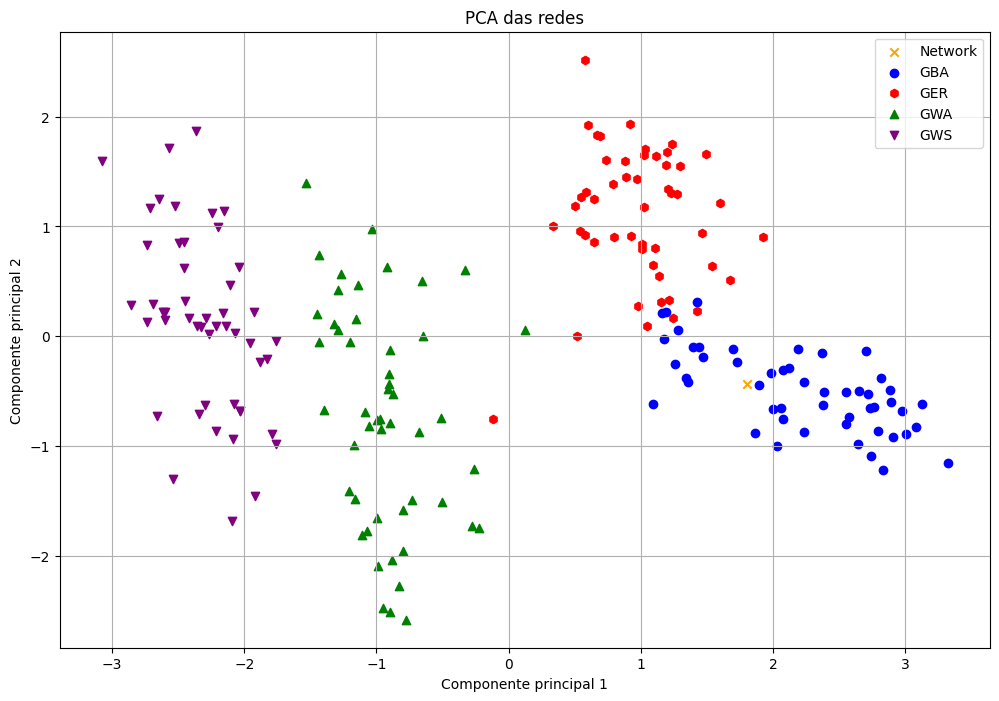

human_prox: GBA, ambass: GBA, ceo: GBA


In [13]:
#Aplicando para as redes sociais
pred_hp, prob_hp, hp_class = classificador(human_prox)

pred_amb, prob_amb, amb_class = classificador(ambass)

pred_ceo, prob_ceo, ceo_class = classificador(ceo)

#verificando se as 3 redes foram classificadas no mesmo modelo
print(f"human_prox: {pred_hp[0]}, ambass: {pred_amb[0]}, ceo: {pred_ceo[0]}")


N:48
M:64
Grau médio: 2.67


<ipython-input-3-147f9f899d1c>:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  vk = sum(d for _, d in G.degree()) / n
/usr/local/lib/python3.11/dist-packages/networkx/algorithms/assortativity/mixing.py:217: RuntimeWarning: invalid value encountered in divide
  a = a / a.sum()


     clustering  avg_path_length  assortatividade  dg_medio       var modelo
0      0.019512         3.592683         0.029010  2.878049  2.204640    GER
1      0.083696         3.154589        -0.019548  3.478261  2.466919    GER
2      0.000000         3.711416         0.020452  2.863636  1.890496    GER
3      0.051220         3.710976         0.098793  2.731707  1.952409    GER
4      0.026515         4.241015        -0.163658  2.590909  1.969008    GER
..          ...              ...              ...       ...       ...    ...
195    0.171264         3.399015         0.100798  2.689655  2.145065    GWA
196    0.031944         3.637681        -0.186461  2.250000  1.104167    GWA
197    0.041667         4.068254         0.070776  2.444444  1.580247    GWA
198    0.024510         5.128342        -0.231003  2.117647  1.044983    GWA
199    0.000000         5.028409        -0.095936  2.121212  1.136823    GWA

[150 rows x 6 columns]


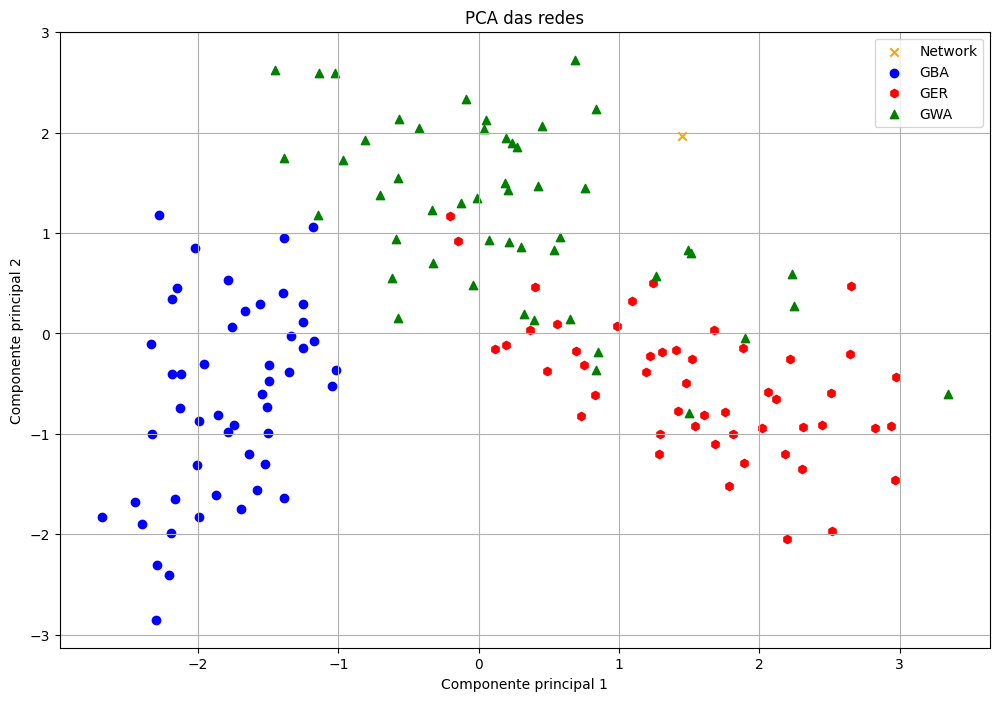

N:105
M:292
Grau médio: 5.56


<ipython-input-3-147f9f899d1c>:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  vk = sum(d for _, d in G.degree()) / n


     clustering  avg_path_length  assortatividade  dg_medio       var modelo
0      0.050469         2.795604        -0.003298  5.866667  3.220317    GER
1      0.046291         2.843773        -0.075546  5.600000  5.668571    GER
2      0.047748         2.883869        -0.075309  5.442308  5.804364    GER
3      0.069101         2.723443        -0.120315  6.133333  5.467937    GER
4      0.038422         2.924176         0.003077  5.390476  5.247528    GER
..          ...              ...              ...       ...       ...    ...
195    0.050345         3.175112        -0.029727  4.627451  4.625913    GWA
196    0.024945         3.473077         0.044592  4.038095  4.531882    GWA
197    0.043433         3.200606         0.007282  4.480000  4.909600    GWA
198    0.044194         3.400533        -0.063326  4.174757  3.988877    GWA
199    0.043032         2.991243         0.054962  5.165049  5.069846    GWA

[200 rows x 6 columns]


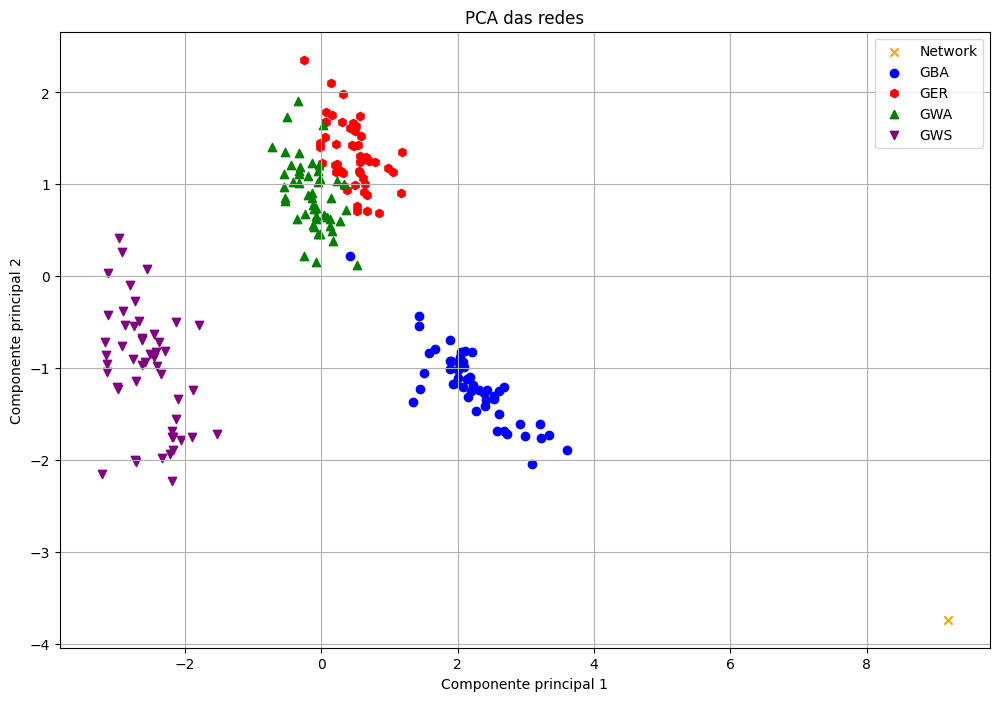

N:3015
M:5156
Grau médio: 3.42


<ipython-input-3-147f9f899d1c>:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  vk = sum(d for _, d in G.degree()) / n
/usr/local/lib/python3.11/dist-packages/networkx/algorithms/assortativity/mixing.py:217: RuntimeWarning: invalid value encountered in divide
  a = a / a.sum()


     clustering  avg_path_length  assortatividade    dg_medio         var  \
0      0.000209         6.584186        -0.023937    3.509906    3.139718   
1      0.000804         6.494599        -0.005128    3.592810    3.131120   
2      0.001623         6.524869        -0.038932    3.575404    3.074270   
3      0.000744         6.546156         0.011424    3.555709    3.039284   
4      0.000632         6.504094        -0.005712    3.600554    3.084472   
..          ...              ...              ...         ...         ...   
195    0.045713         1.963777         0.040869  129.172139  377.985957   
196    0.045369         1.964431         0.051180  128.311774  357.349563   
197    0.045596         1.963350         0.046645  129.418905  349.557520   
198    0.045992         1.963448         0.046014  129.811609  394.523049   
199    0.046056         1.963229         0.048264  129.996020  387.672289   

    modelo  
0      GER  
1      GER  
2      GER  
3      GER  
4      GER

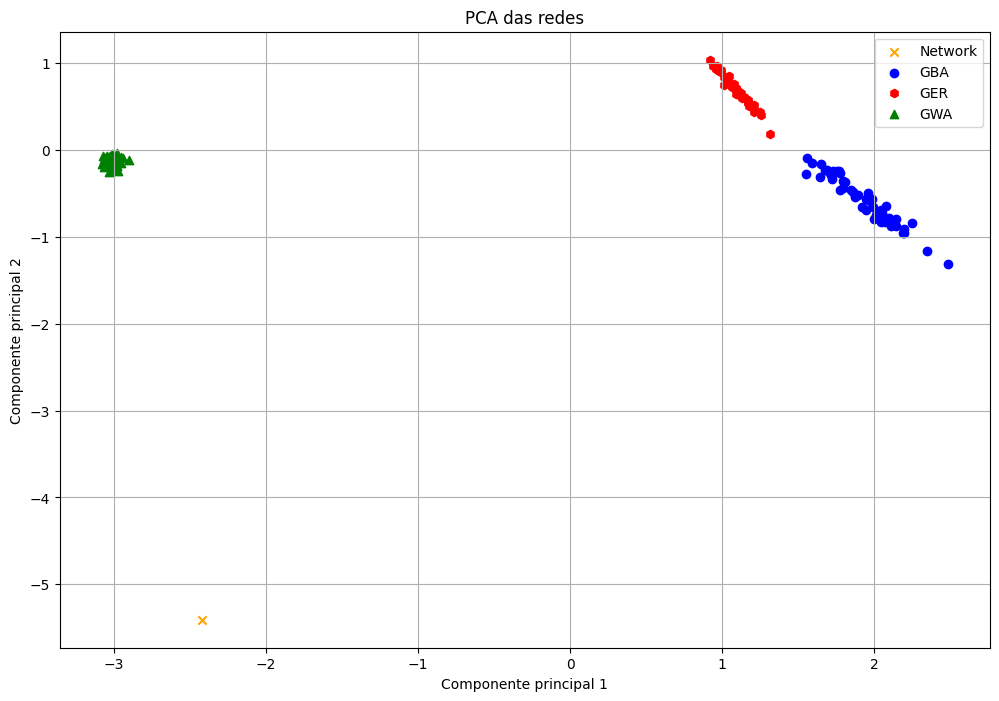

bell: GWA, junit: GBA, edges: GBA


In [14]:
#Aplicando para as redes tecnológicas
pred_bell, prob_bell, bell_class = classificador(bell)
pred_junit, prob_junit, junit_class = classificador(junit)
pred_edges, prob_edges, edges_class = classificador(edges)

#verificando se as 3 redes foram classificadas no mesmo modelo
print(f"bell: {pred_bell[0]}, junit: {pred_junit[0]}, edges: {pred_edges[0]}")


N:183
M:2434
Grau médio: 26.60


<ipython-input-3-147f9f899d1c>:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  vk = sum(d for _, d in G.degree()) / n


     clustering  avg_path_length  assortatividade   dg_medio        var modelo
0      0.144751         1.864889        -0.002959  27.125683  20.011526    GER
1      0.151564         1.860325        -0.005034  27.584699  20.996924    GER
2      0.147828         1.863448         0.007236  27.344262  22.433396    GER
3      0.138735         1.877379        -0.004711  25.748634  15.455941    GER
4      0.147765         1.865129        -0.020707  26.972678  18.551166    GER
..          ...              ...              ...        ...        ...    ...
195    0.050601         2.817510        -0.010794   7.377049   6.639255    GWA
196    0.047264         2.858464        -0.003648   7.136612   8.063304    GWA
197    0.035473         2.892632        -0.043446   6.885246   6.549673    GWA
198    0.049339         2.740107         0.031767   7.890710   7.714832    GWA
199    0.049471         2.901699         0.025401   7.005464   7.229478    GWA

[200 rows x 6 columns]


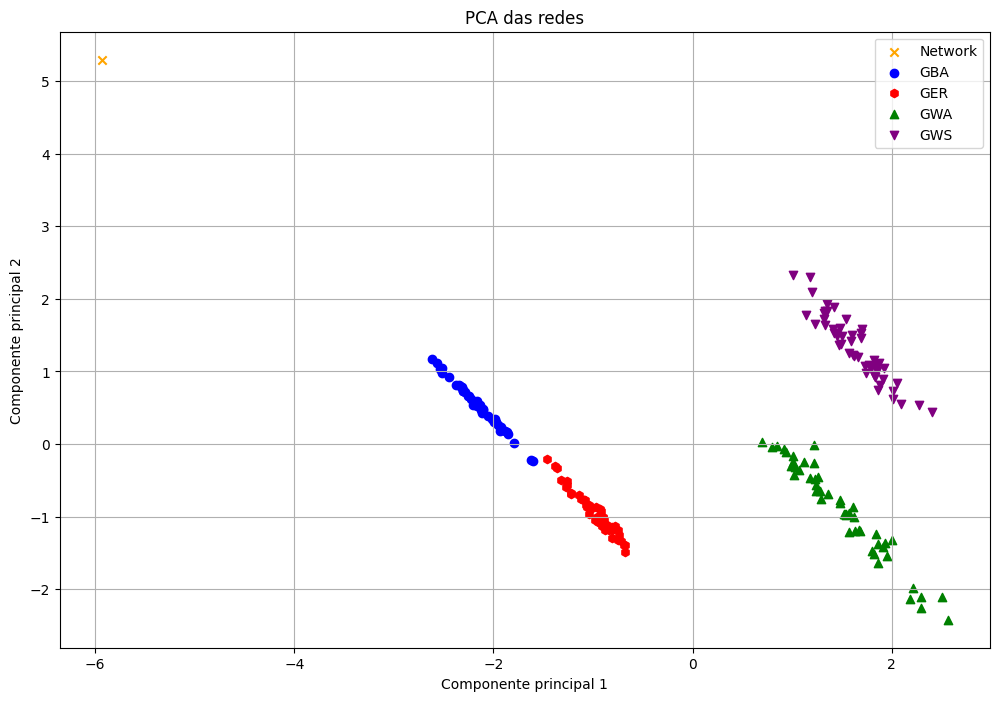

N:328
M:456
Grau médio: 2.78


<ipython-input-3-147f9f899d1c>:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  vk = sum(d for _, d in G.degree()) / n
/usr/local/lib/python3.11/dist-packages/networkx/algorithms/assortativity/mixing.py:217: RuntimeWarning: invalid value encountered in divide
  a = a / a.sum()


     clustering  avg_path_length  assortatividade   dg_medio        var modelo
0      0.007660         5.481631        -0.034080   2.973684   2.374307    GER
1      0.021469         5.465929        -0.035107   3.003390   2.491514    GER
2      0.004171         5.464897         0.035191   2.949495   2.606877    GER
3      0.012645         5.755194         0.006292   2.935897   2.207429    GER
4      0.004699         5.477977        -0.028933   2.996721   2.357366    GER
..          ...              ...              ...        ...        ...    ...
195    0.046181         2.556407        -0.006640  12.756098  16.397829    GWA
196    0.046735         2.501529         0.009217  13.725610  19.028369    GWA
197    0.048020         2.529555        -0.013009  13.237805  13.589790    GWA
198    0.047859         2.476393        -0.018863  14.201220  18.270486    GWA
199    0.041095         2.525528        -0.034623  13.225610  14.851539    GWA

[150 rows x 6 columns]


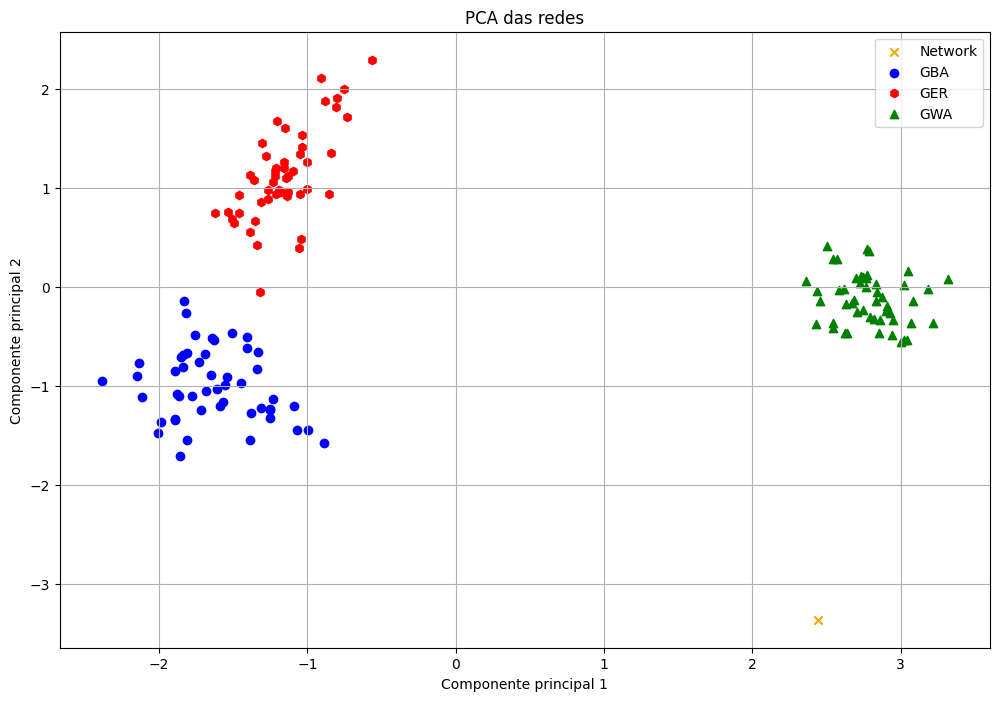

N:664
M:1065
Grau médio: 3.21


<ipython-input-3-147f9f899d1c>:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  vk = sum(d for _, d in G.degree()) / n
/usr/local/lib/python3.11/dist-packages/networkx/algorithms/assortativity/mixing.py:217: RuntimeWarning: invalid value encountered in divide
  a = a / a.sum()


     clustering  avg_path_length  assortatividade   dg_medio        var modelo
0      0.001625         5.446630         0.065539   3.397174   3.084011    GER
1      0.005822         5.775094         0.040698   3.242038   2.571991    GER
2      0.004564         5.692344         0.027315   3.337621   2.574115    GER
3      0.001606         5.605441         0.036180   3.343949   2.751126    GER
4      0.004033         5.419031         0.000497   3.456869   2.842389    GER
..          ...              ...              ...        ...        ...    ...
195    0.045022         2.251472         0.007982  28.186747  41.007294    GWA
196    0.044354         2.285522         0.012721  26.930723  35.172912    GWA
197    0.045988         2.246883         0.005328  28.391566  38.702098    GWA
198    0.045225         2.252521         0.013554  28.177711  39.170226    GWA
199    0.044135         2.264306         0.000249  27.656627  37.373058    GWA

[150 rows x 6 columns]


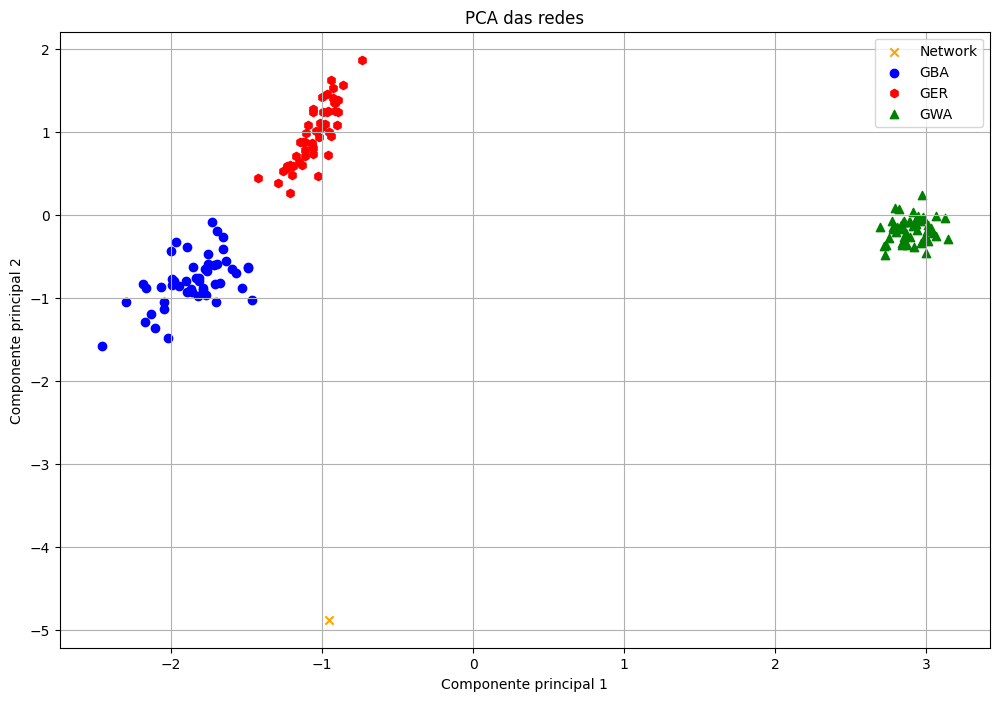

rock: GBA, ecoli: GWA, yeast: GBA


In [15]:
#Aplicando para as redes biológicas
pred_rock, prob_rock, rock_class = classificador(rock)

pred_ecoli, prob_ecoli, ecoli_class = classificador(ecoli)

pred_yeast, prob_yeast, yeast_class = classificador(yeast)

#verificando se as 3 redes foram classificadas no mesmo modelo
print(f"rock: {pred_rock[0]}, ecoli: {pred_ecoli[0]}, yeast: {pred_yeast[0]}")


Apenas verificando algumas das probabilidades achadas ao usar regressão logística

In [24]:
raw_probs = prob_hp[0]

probs_dict = dict(zip(hp_class, raw_probs))

print(f"Predição: {pred_hp[0]}")
for modelo, p in probs_dict.items():
    print(f"  {modelo:>4} : {p*100:6.2f}%")

Predição: GBA
   GBA : 100.00%
   GER :   0.00%
   GWA :   0.00%
   GWS :   0.00%


In [23]:
raw_probs = prob_amb[0]

probs_dict = dict(zip(amb_class, raw_probs))

print(f"Predição: {pred_amb[0]}")
for modelo, p in probs_dict.items():
    print(f"  {modelo:>4} : {p*100:6.2f}%")

Predição: GBA
   GBA :  98.45%
   GER :   1.55%
   GWA :   0.00%
   GWS :   0.00%


In [25]:
raw_probs = prob_ceo[0]
probs_dict = dict(zip(ceo_class, raw_probs))

print(f"Predição: {pred_ceo[0]}")
for modelo, p in probs_dict.items():
    print(f"  {modelo:>4} : {p*100:6.2f}%")

Predição: GBA
   GBA :  80.26%
   GER :  19.02%
   GWA :   0.70%
   GWS :   0.03%


##Conclusão

**Hipótese: redes do mesmo tipo (biológica, social e tecnológica) seguem o mesmo modelo.**

Para classificação das redes sociais e biológicas todas redes selecionadas convergiram para o modelo de Barabási. Já para as redes tecnológicas,tivemos uma divergência, as redes convergiram para: Waxman e Barabási. Tendo isso em vista podemos pressupor o porque desse comportamento. Tanto para redes sociais quanto biológicas elas seguem o comportamento sem escala em que temos ligações preferênciais, o que é bem capturado pelo modelo Barabasial. Enquanto nas redes tecnológicas fatores externos como distância, custo e outros, modelam as ligações. Sendo assim, outros modelos como Waxman, que inclui restrições espaciais, podem se encaixar melhor para classificação das redes, como ocorreu. Nesse caso o modelo de waxman inclui um decaimento exponencial de probabilidade de ligação com a distância que representa de forma mais fidedigna a rede "Internet Top Pop Bellcanada", por exemplo. Esse comportamento poderia ser visto em outras redes. Portanto não podemos tomar como verdade a hipótese proposta, pois a depender do tipo da rede isso pode não ser verdade.